In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

mtx  = []
dist = []
img_size = (1280, 720)



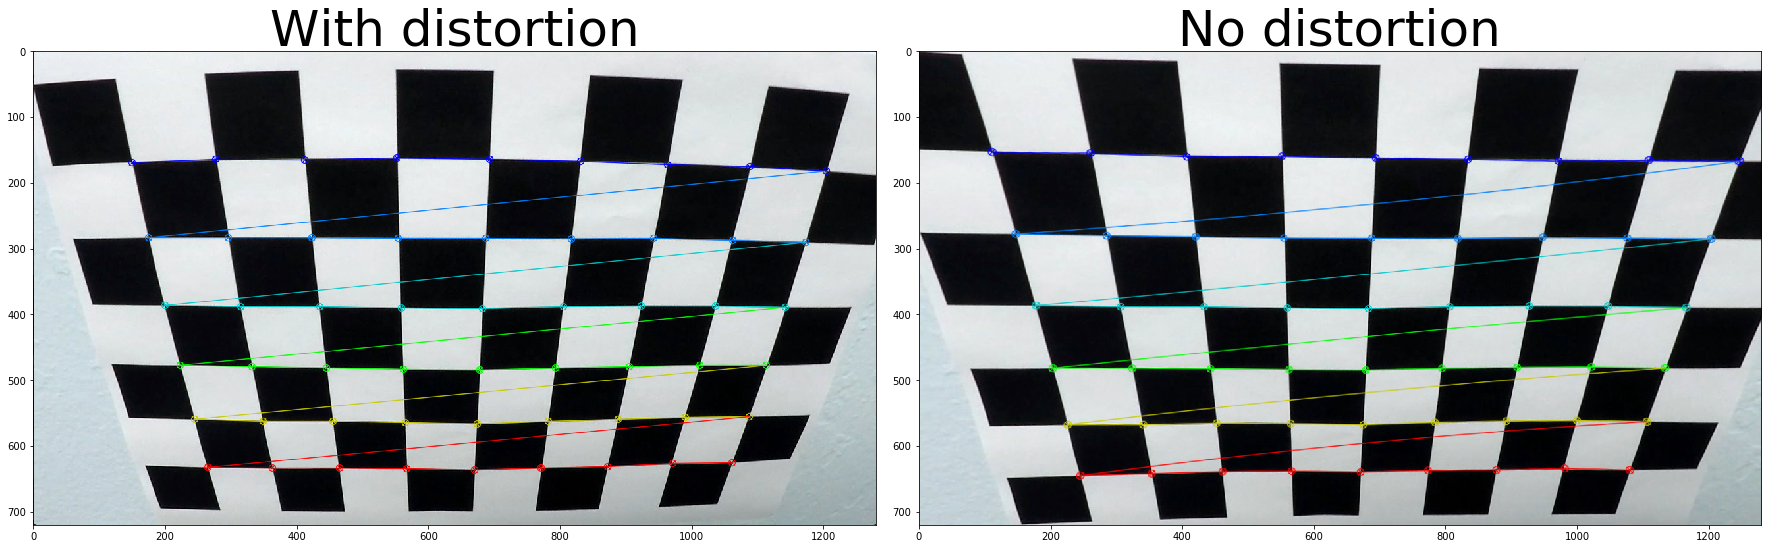

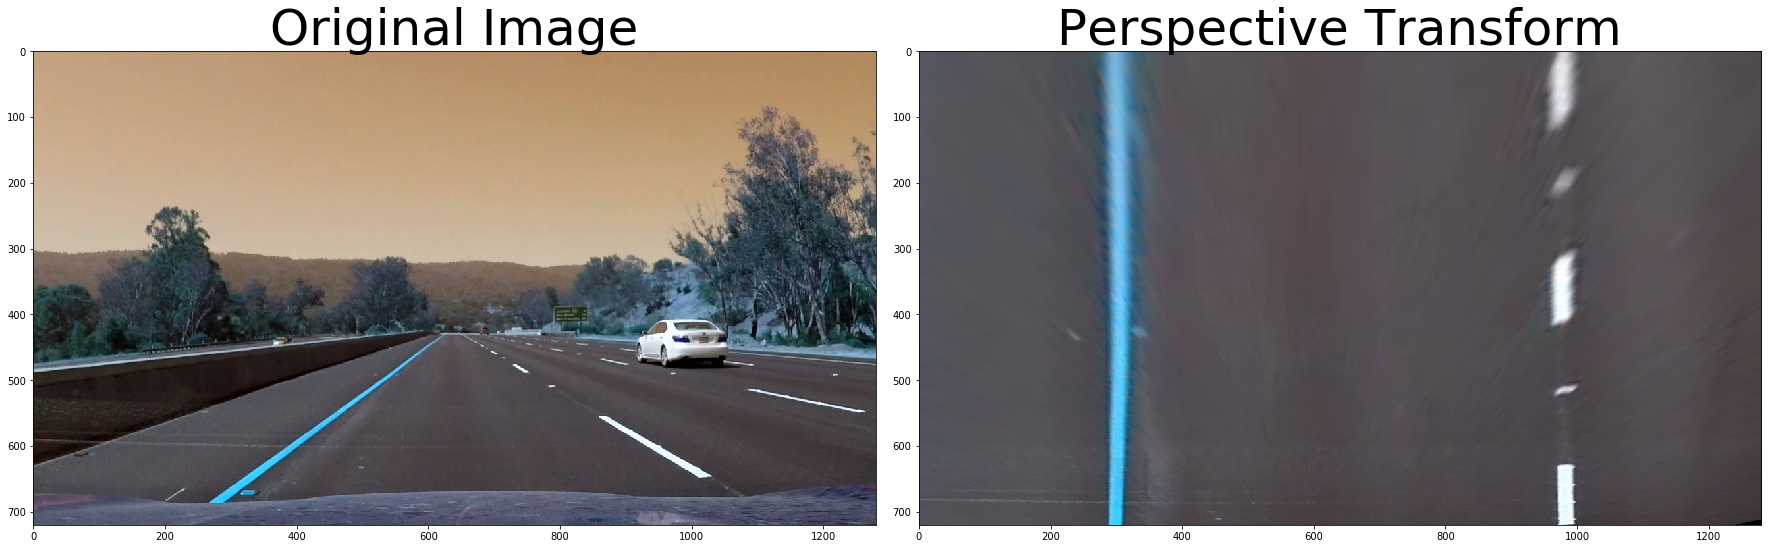

In [2]:
def multiPlot(img1, title1, img2, title2, video=False):
    if not video:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img1)
        ax1.set_title(title1, fontsize=50)
        ax2.imshow(img2)
        ax2.set_title(title2, fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return

def calibrateCamera():
    global mtx
    global dist
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/*.jpg')
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        # Open file and resize image to a consistant size
        img = cv2.imread(fname)
        img = cv2.resize(img,img_size, interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            #Save example image
            if "calibration2.jpg" in fname:
                imgExIn = img.copy();
                cv2.drawChessboardCorners(imgExIn, (9,6), corners, ret)
                #cv2.imwrite("output_images/ChessboardCorners.jpg", imgEx)
        
    # Calculate undistort coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (720, 1280), None, None)
    
    #Save example undistorted image
    imgExOut = cv2.undistort(imgExIn, mtx, dist, None, mtx)
    #cv2.imwrite("output_images/UndistortChessboardCorners.jpg", imgEx)
    multiPlot(imgExIn, "With distortion", imgExOut, "No distortion")
    
    return


def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
    

# Calibrate camera
calibrateCamera()

# Setup perspective transform
img = cv2.imread("perspective.png")
offset = 300
src = np.float32([(331, 648), (589, 455), (696, 455), (1021, 648)])
dst = np.float32([(offset, img_size[1]), (offset, 0), (img_size[0]-offset, 0), (img_size[0]-offset, img_size[1])])
warpMatrix   = cv2.getPerspectiveTransform(src, dst)
unwarpMatrix = cv2.getPerspectiveTransform(dst, src)

imgWarped = cv2.warpPerspective(img, warpMatrix, img_size)
multiPlot(img, "Original Image", imgWarped, "Perspective Transform")


In [3]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Return the binary image
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # Return the binary image
    return binary_output

def hls_select(img, s_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    #plt.figure()
    #plt.imshow(s_channel)
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return binary_output


In [4]:
def findLaneLines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, leftx, lefty, rightx, righty

def getCurvature(leftx, lefty, rightx, righty, imageSize):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1280 # meters per pixel in x dimension
    y_eval = imageSize[0]
    height = imageSize[0] * ym_per_pix
    width  = imageSize[1] * xm_per_pix
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate car deviation
    left_lane = left_fit_cr[0]*height**2 + left_fit_cr[1]*height + left_fit_cr[2]
    right_lane = right_fit_cr[0]*height**2 + right_fit_cr[1]*height + right_fit_cr[2]
    lane_center = (right_lane + left_lane) / 2.
    lane_deviation = (width / 2.) - lane_center

    return left_curverad, right_curverad, lane_deviation

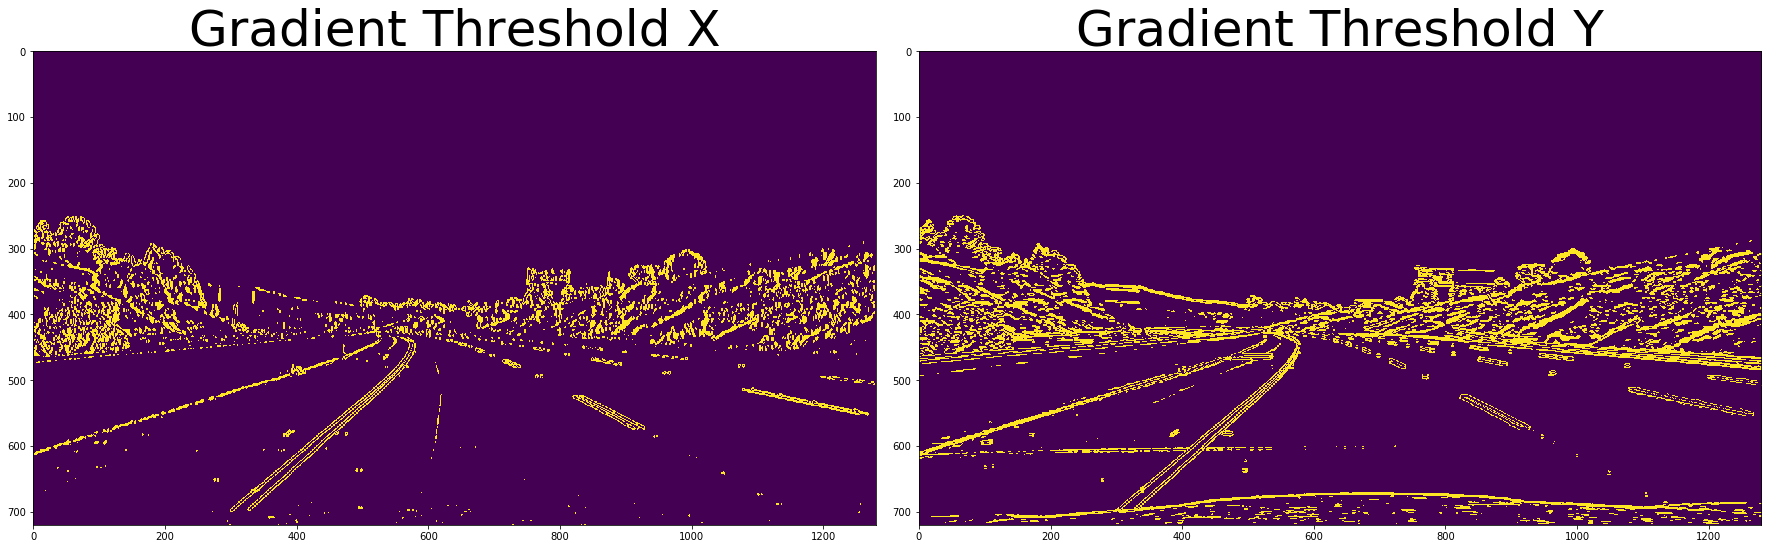

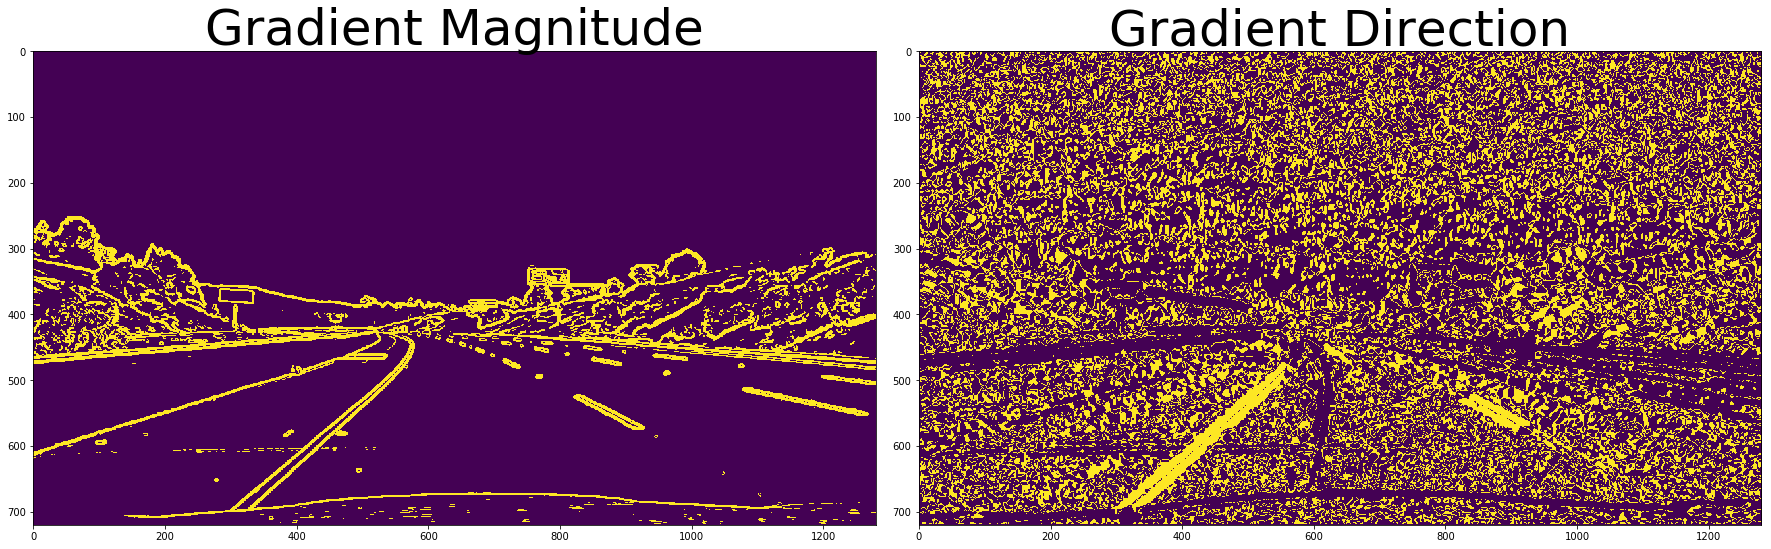

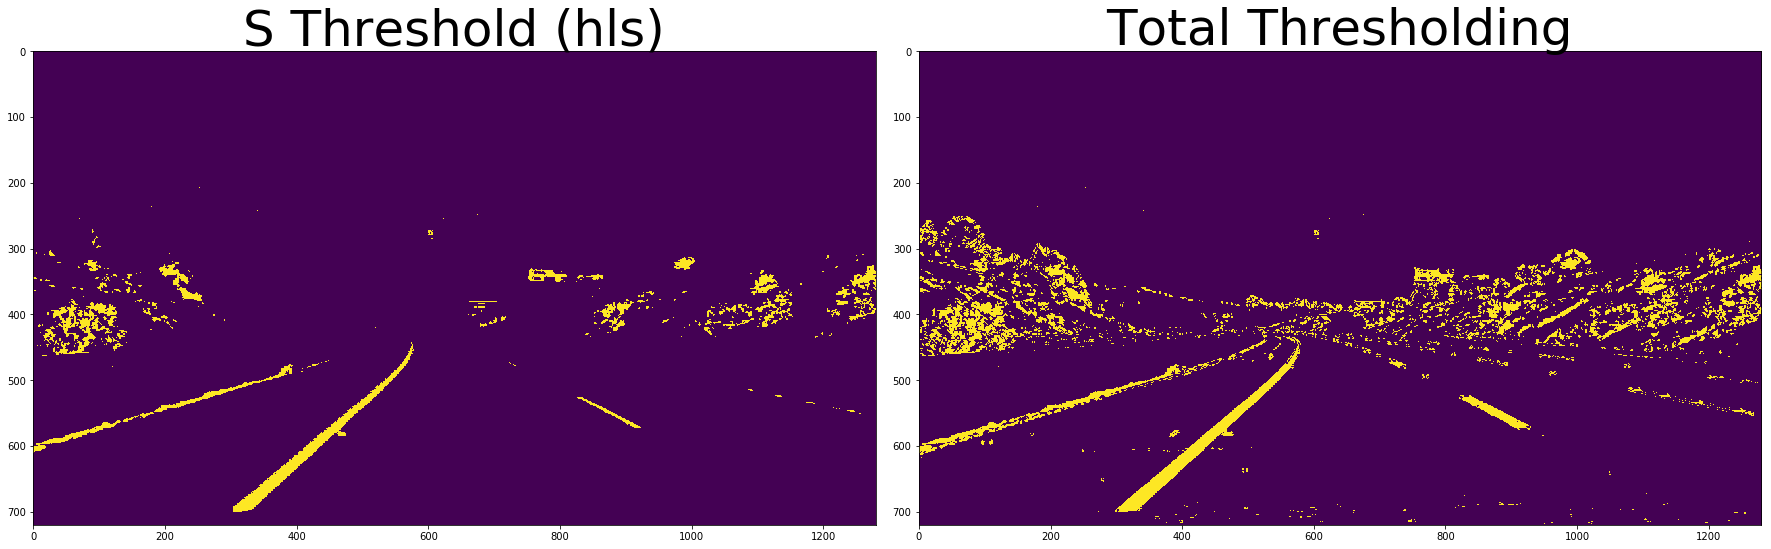

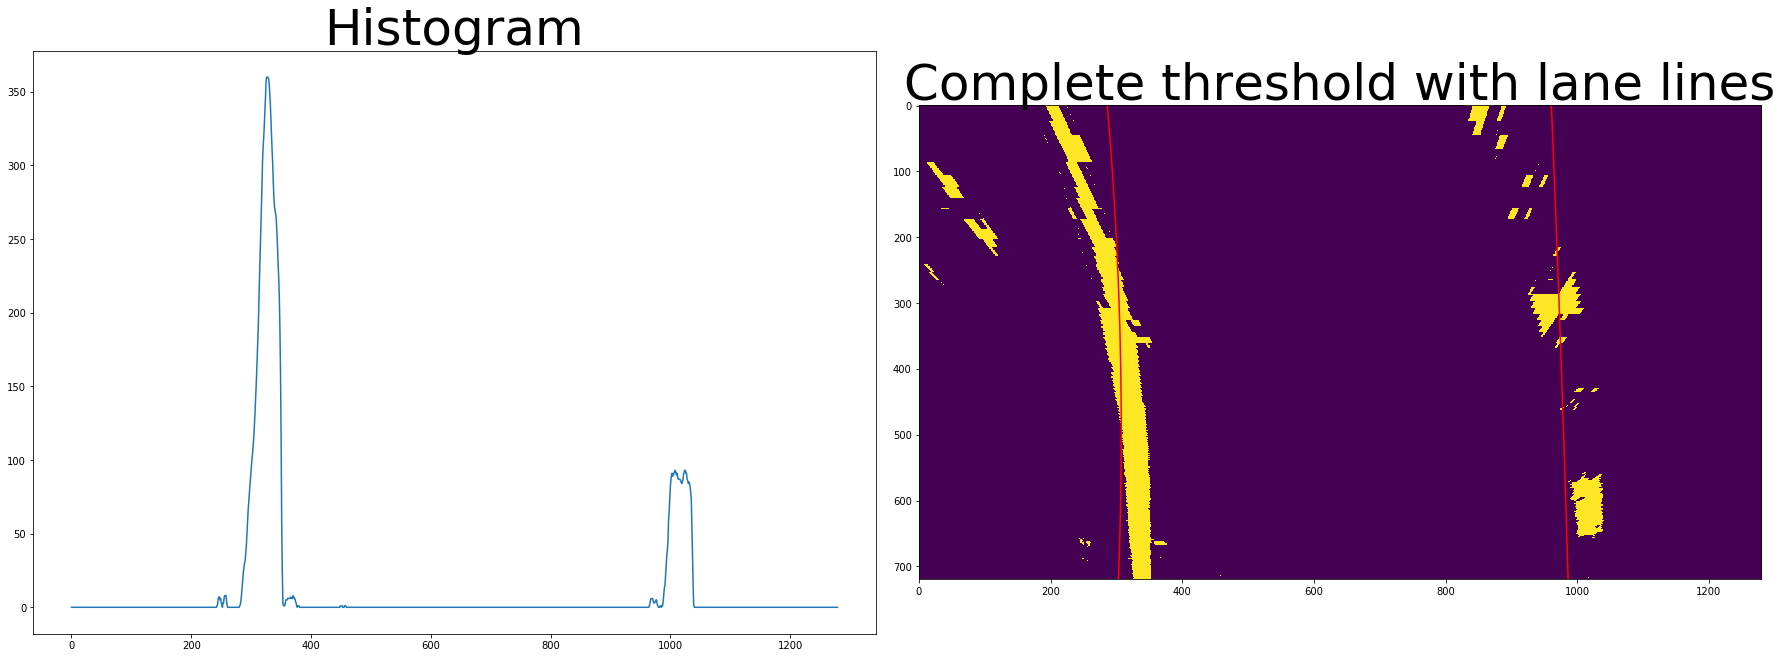

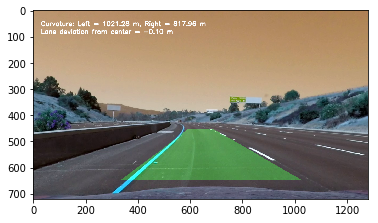

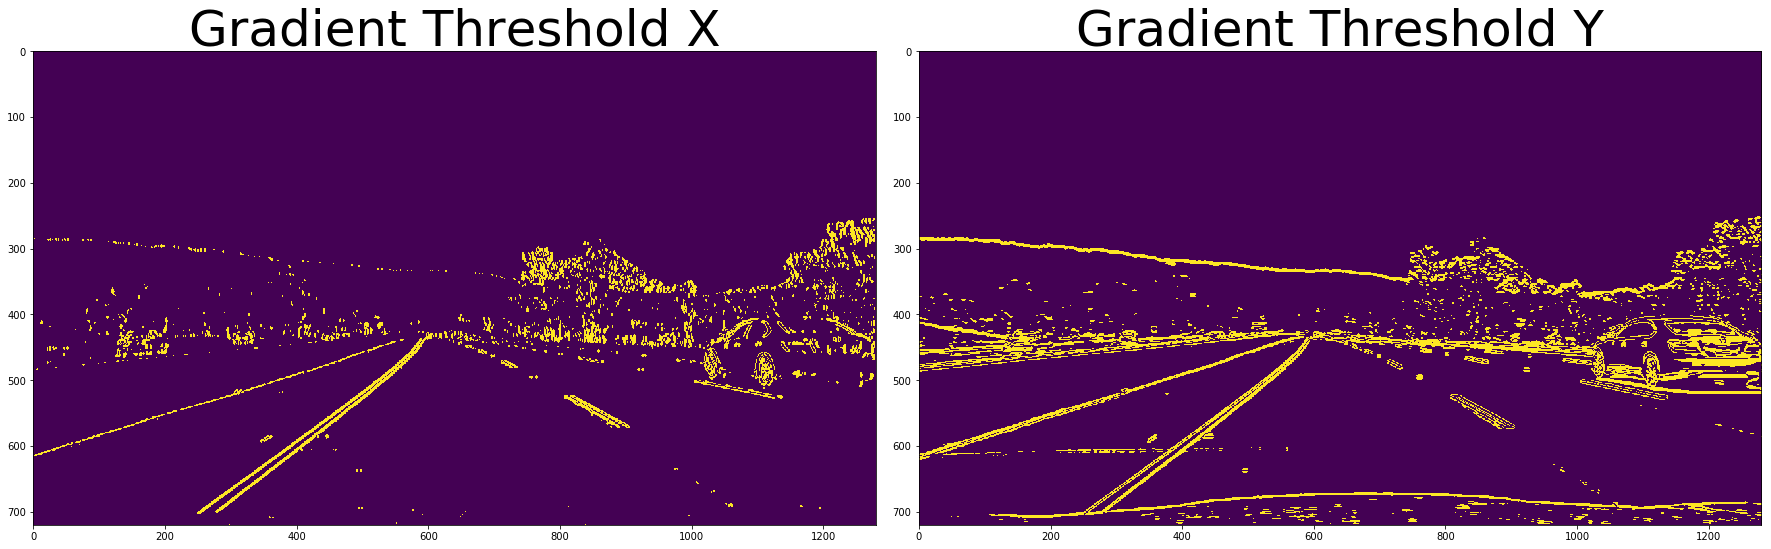

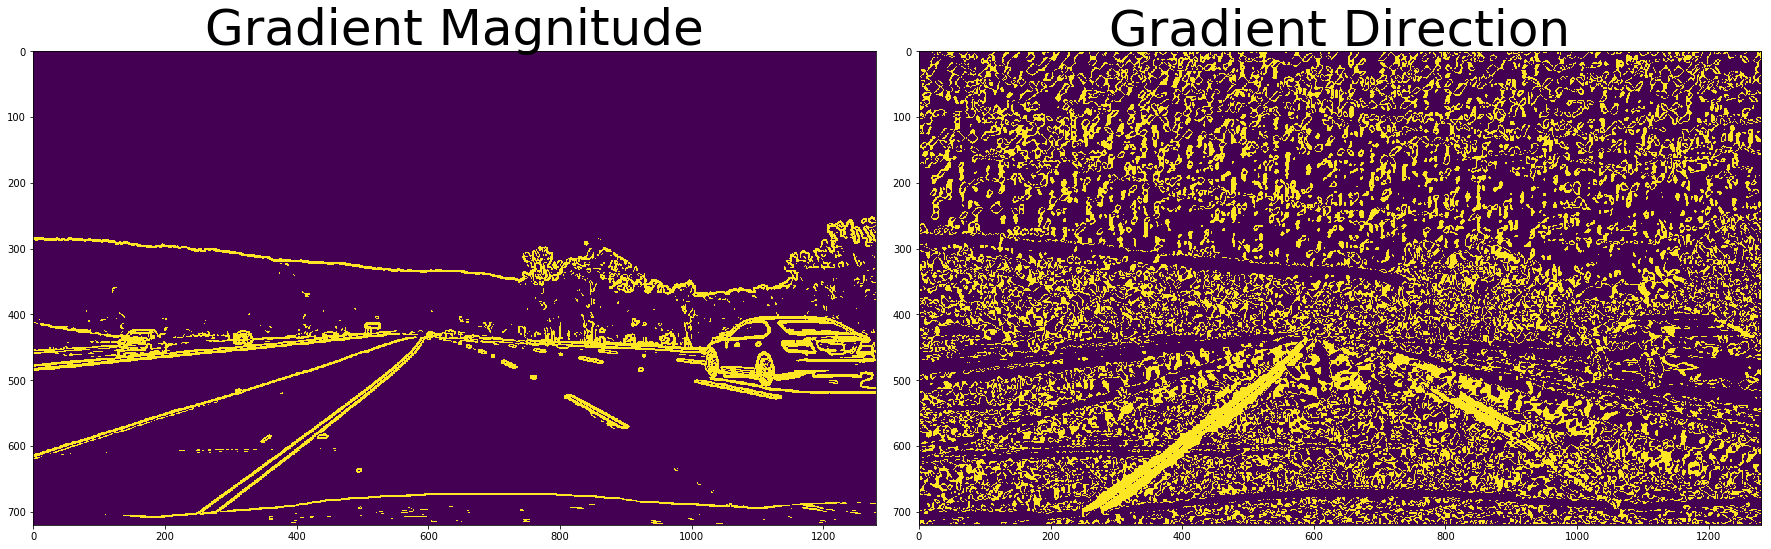

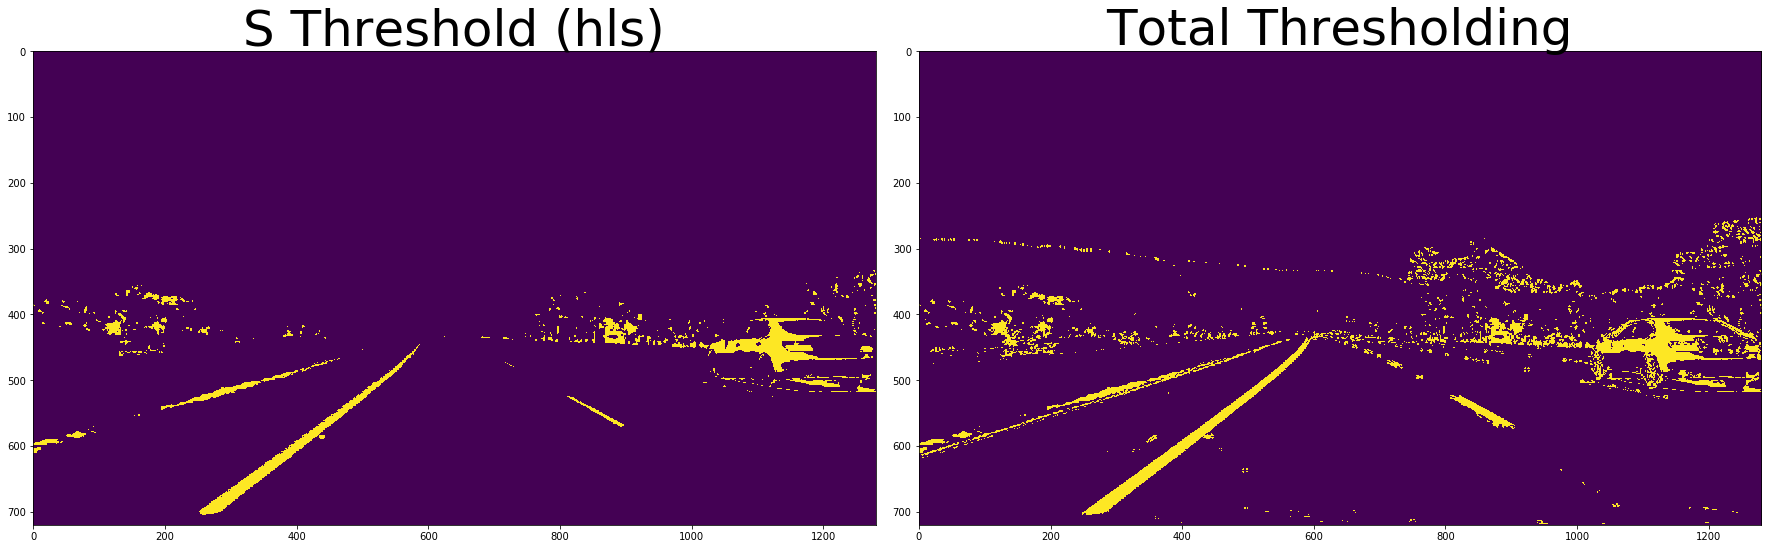

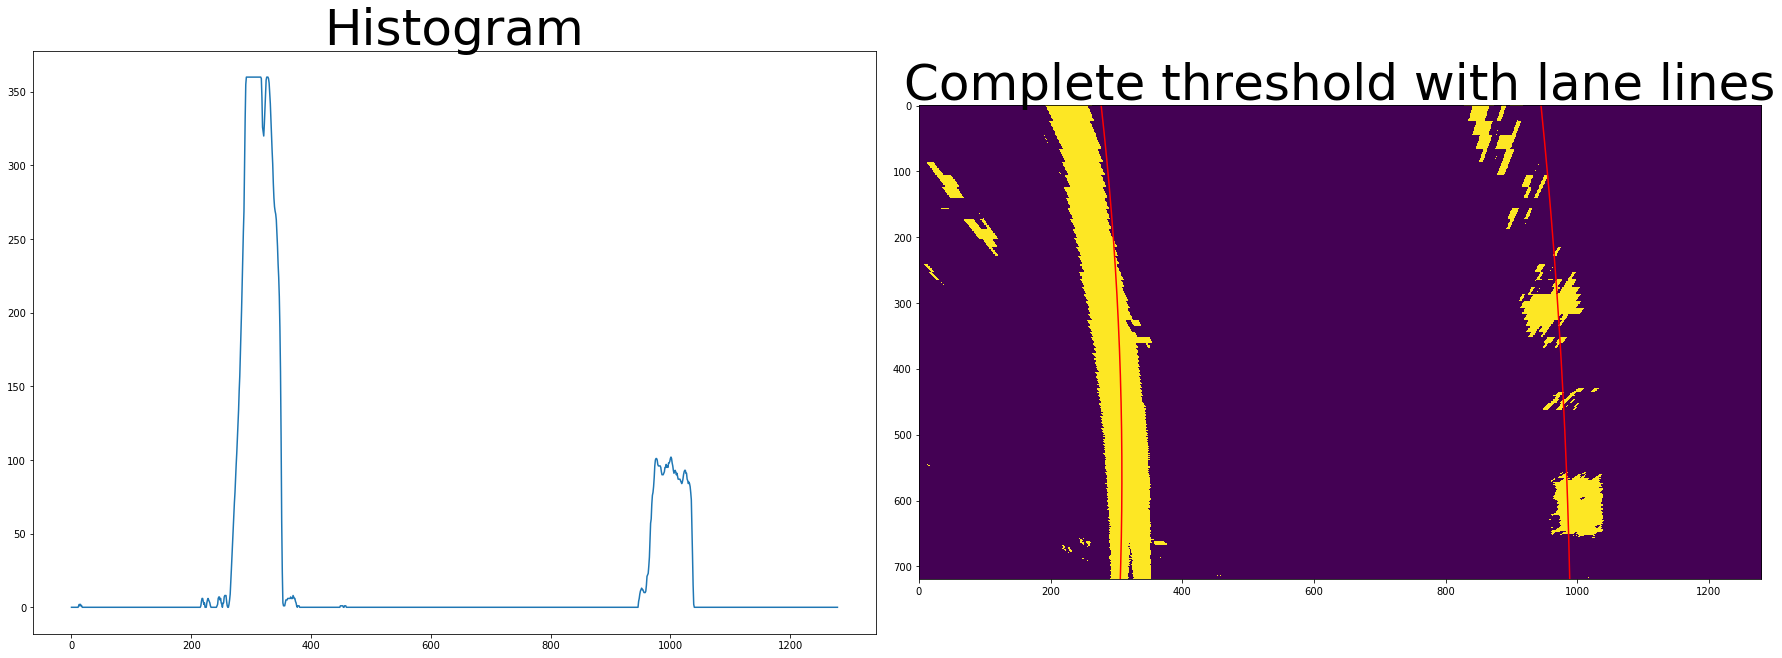

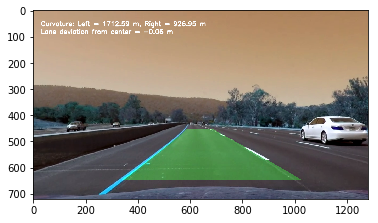

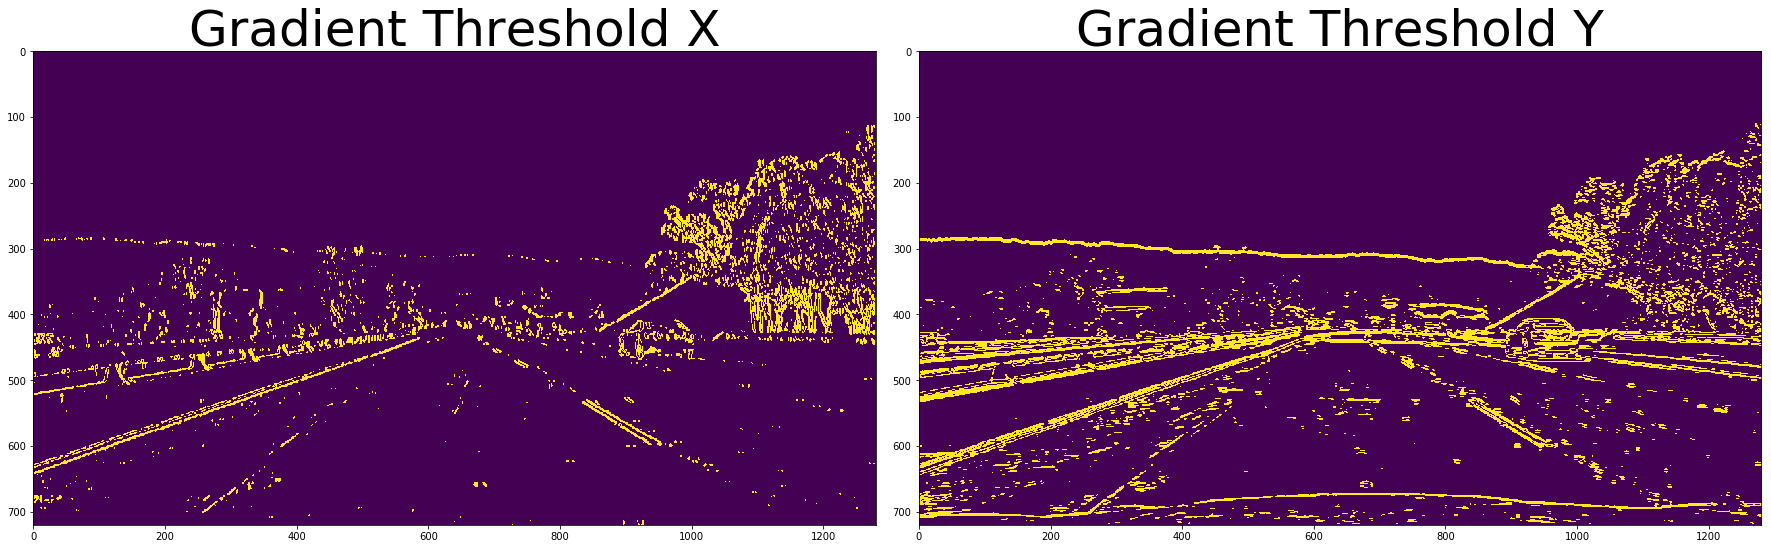

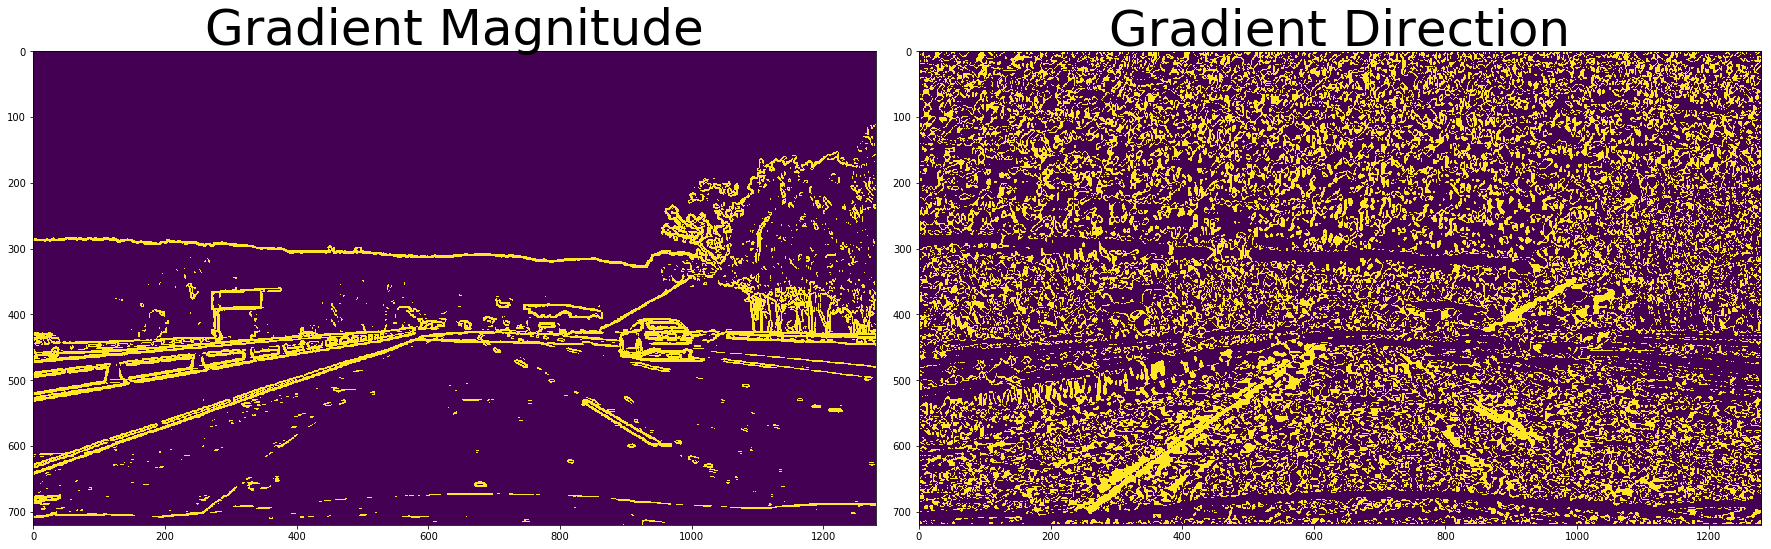

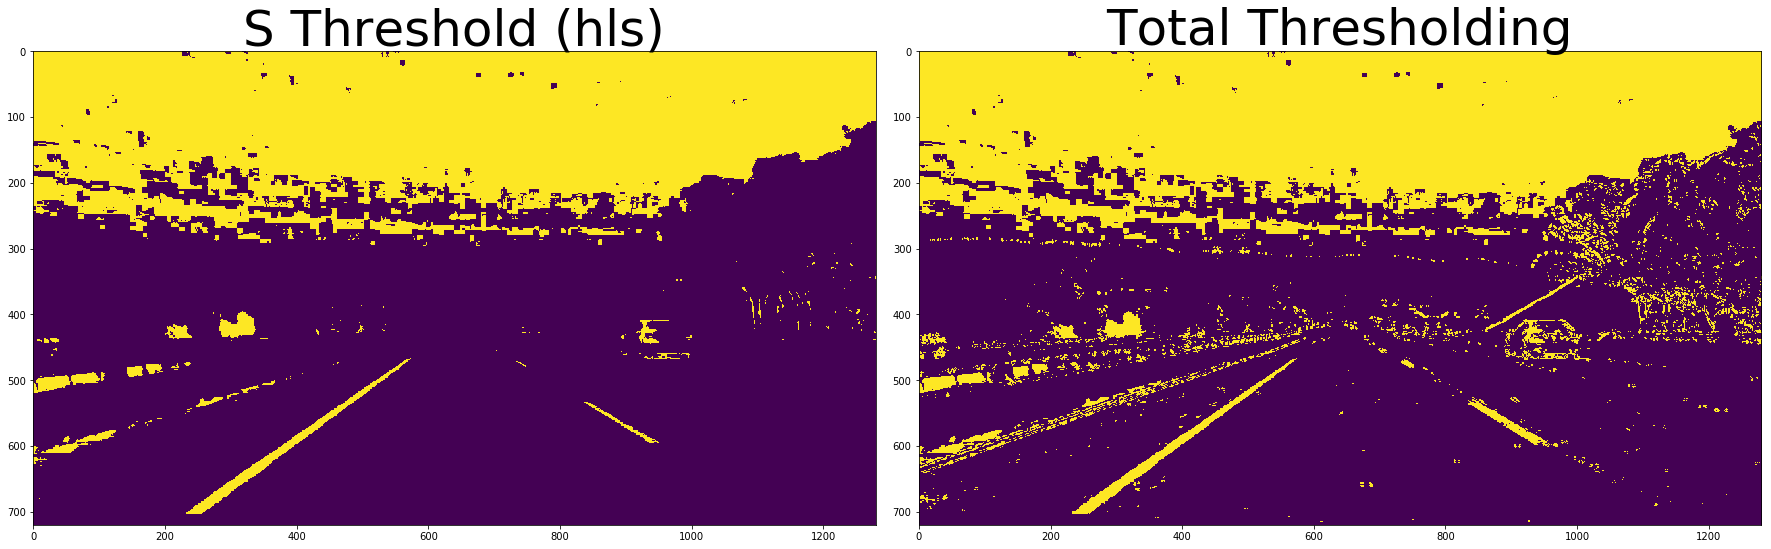

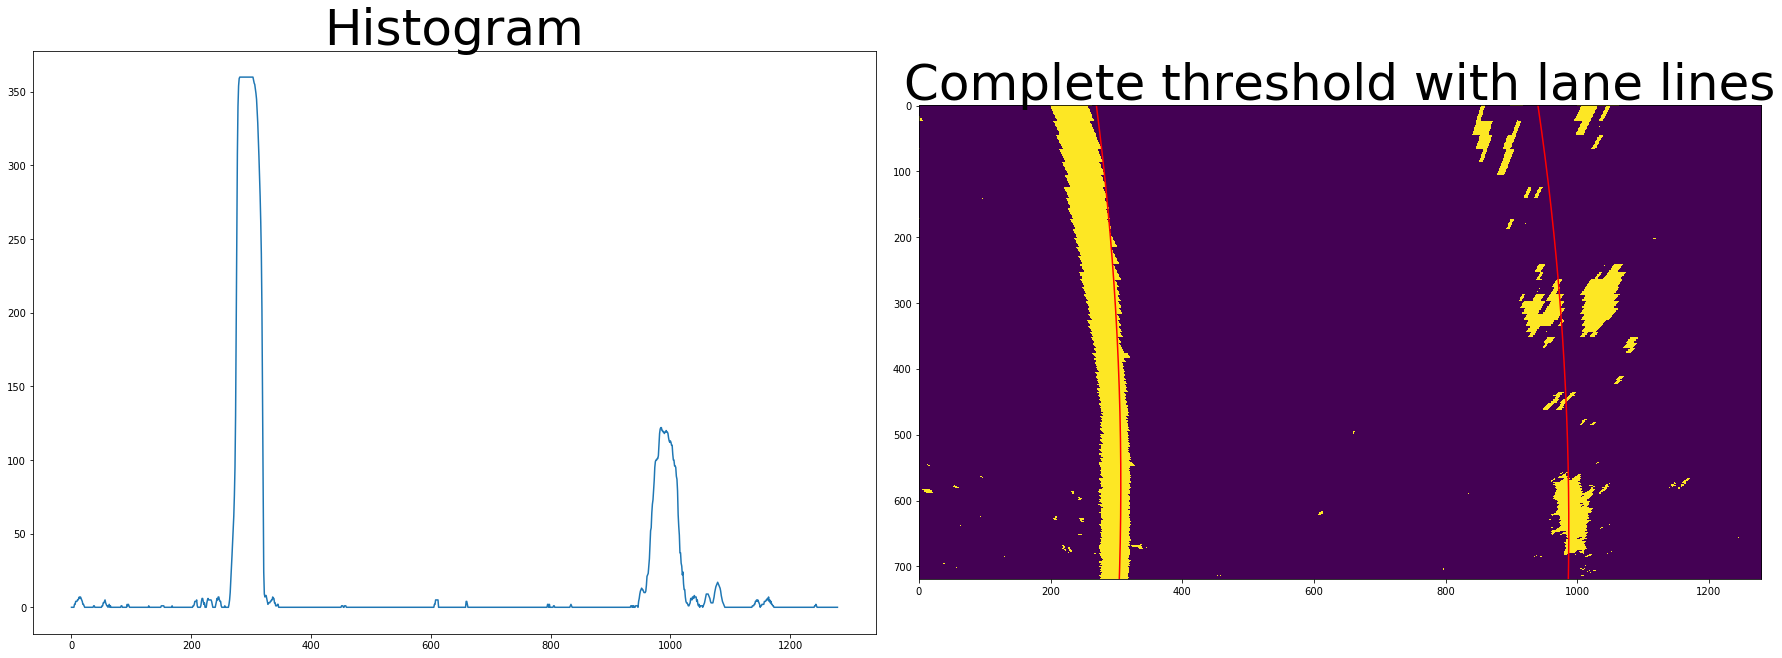

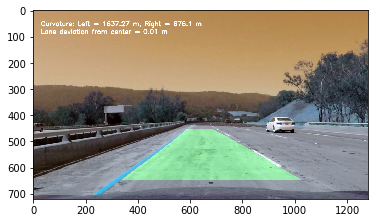

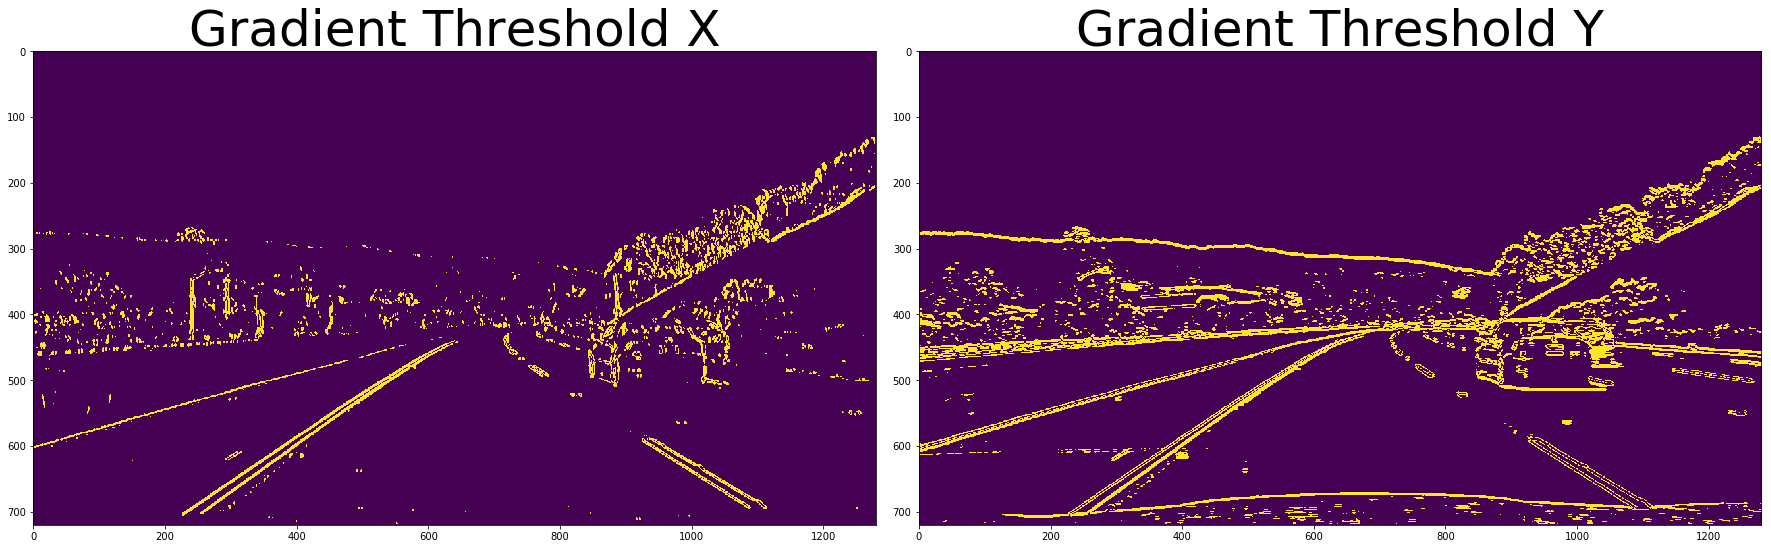

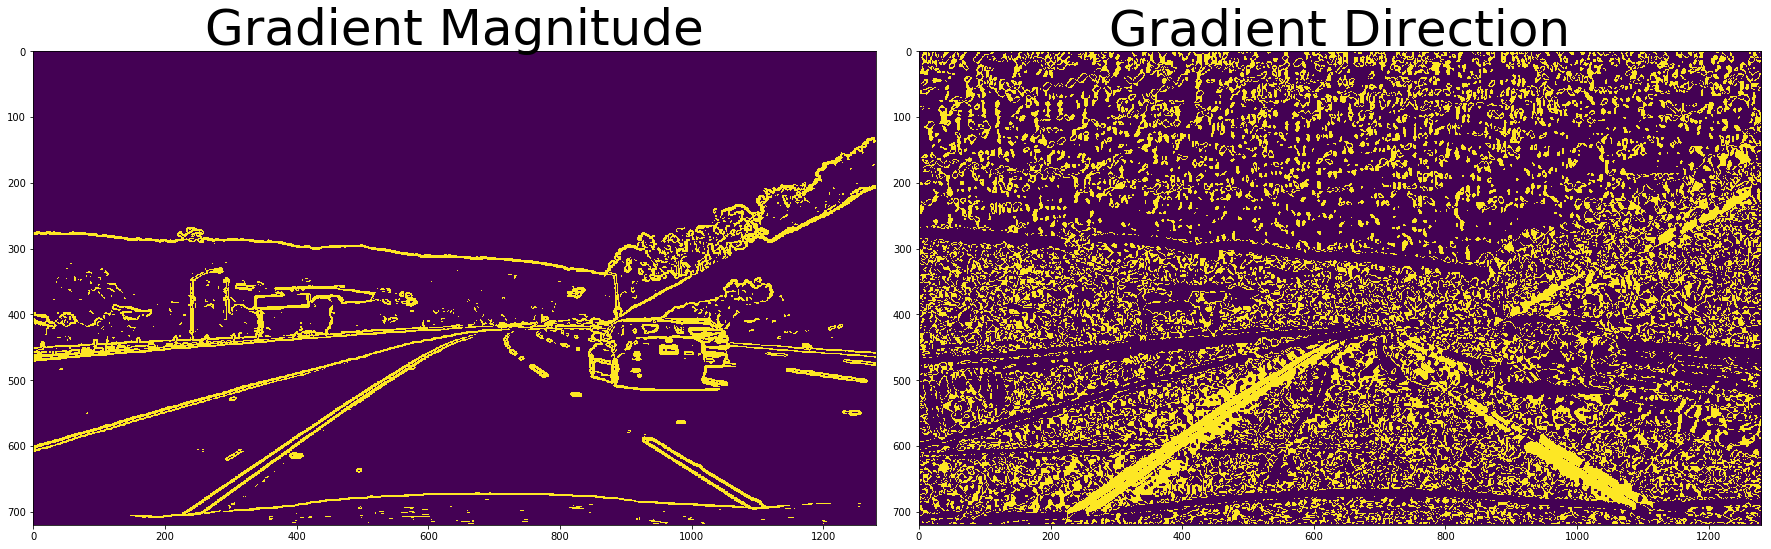

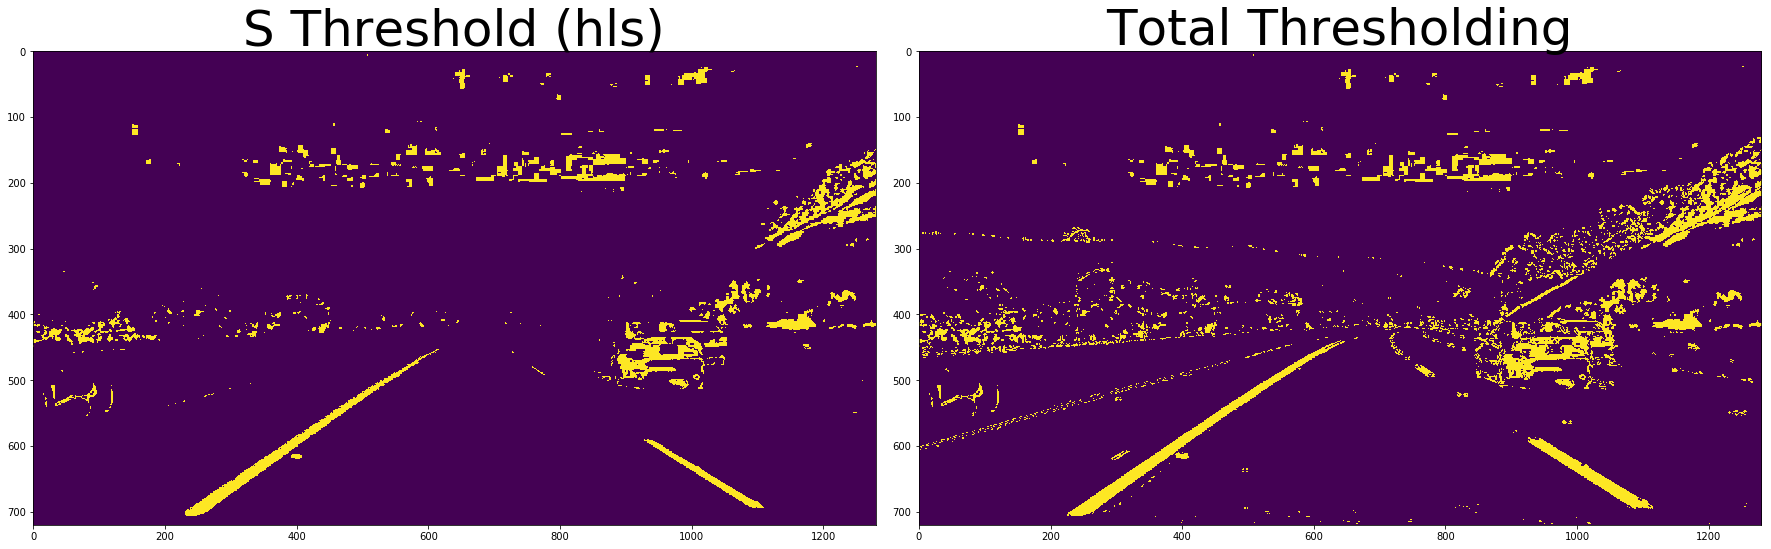

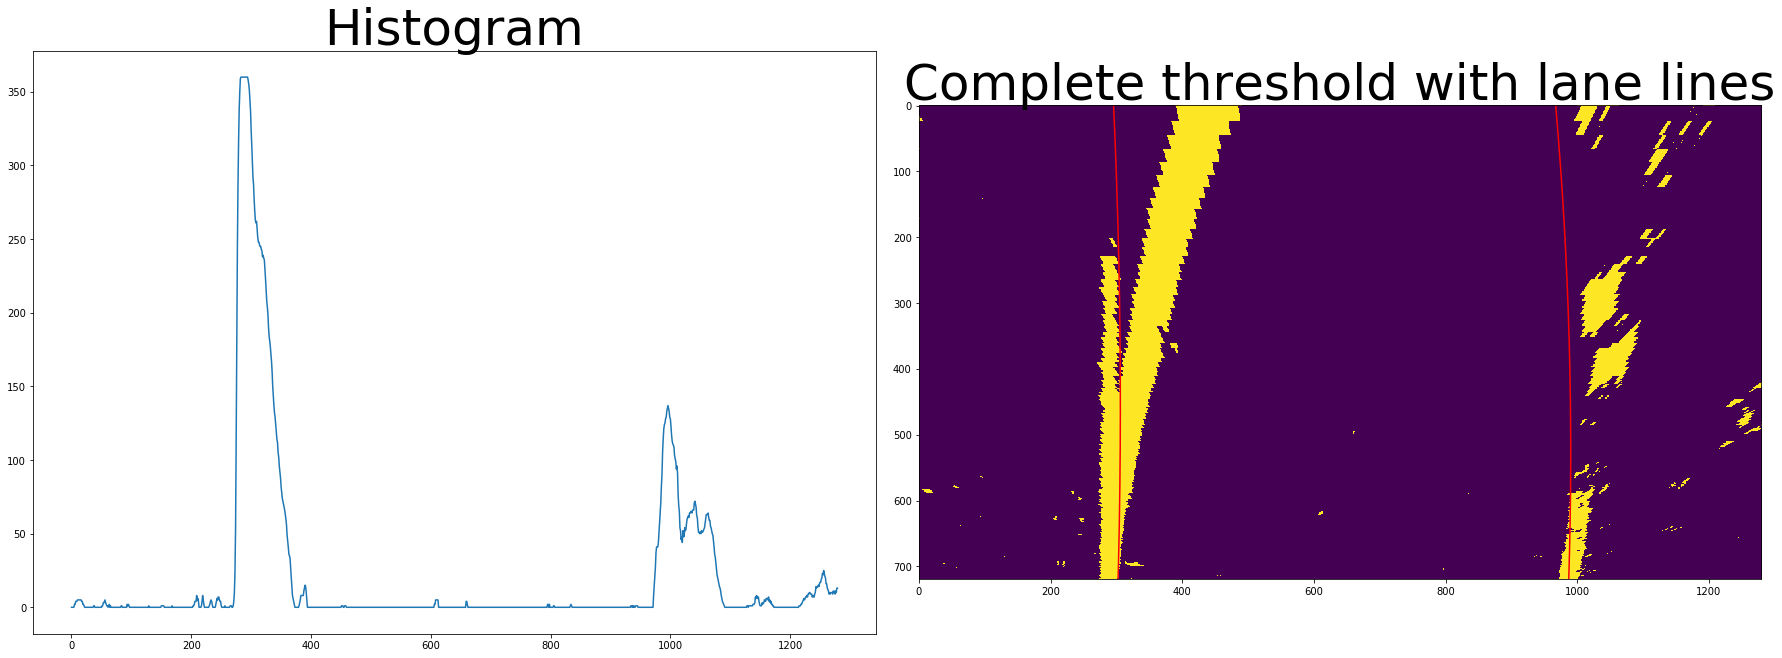

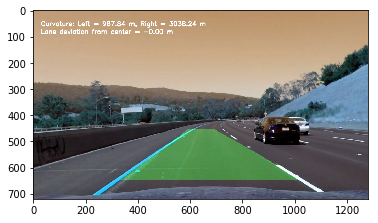

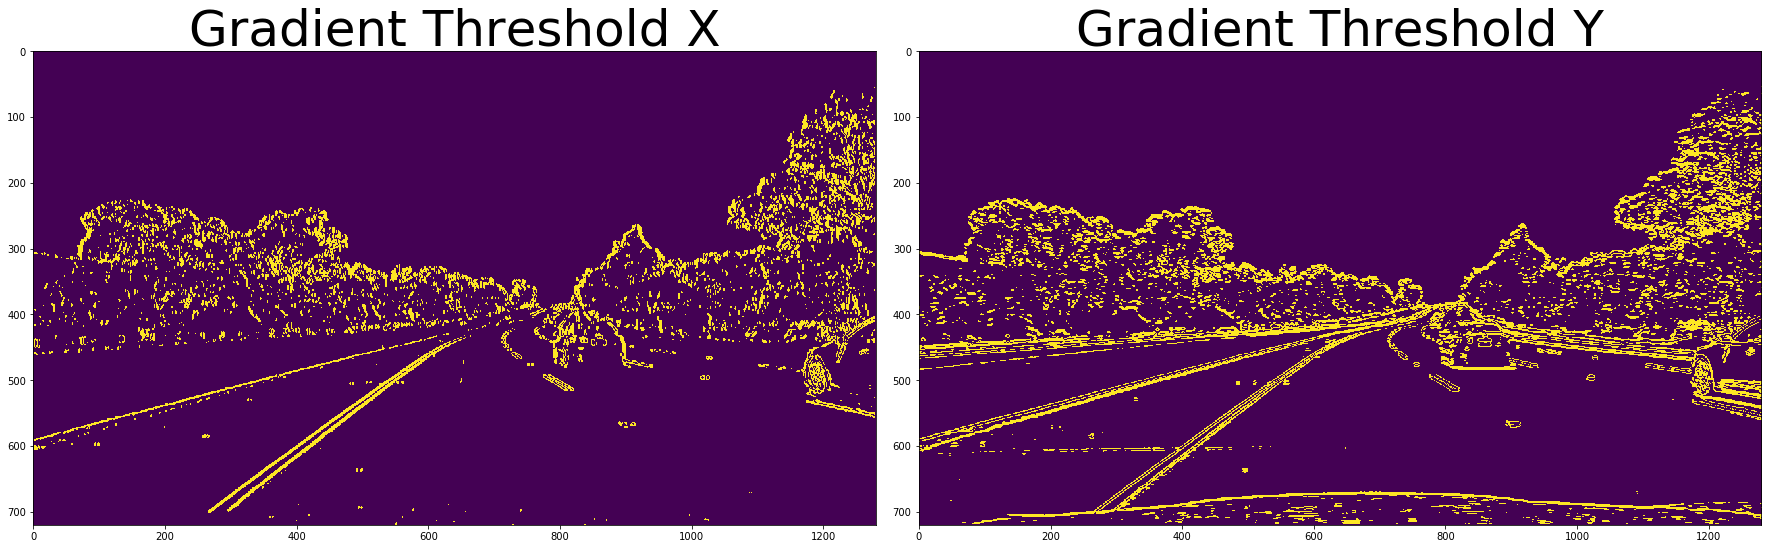

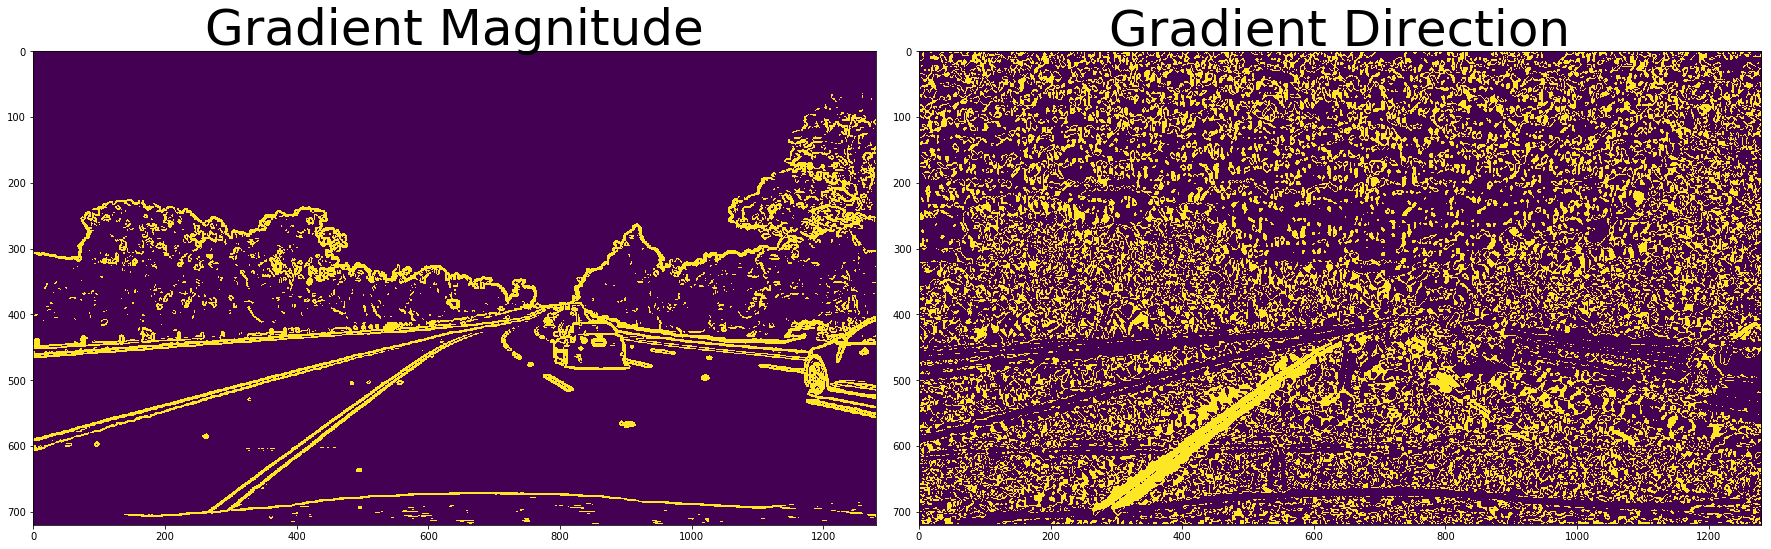

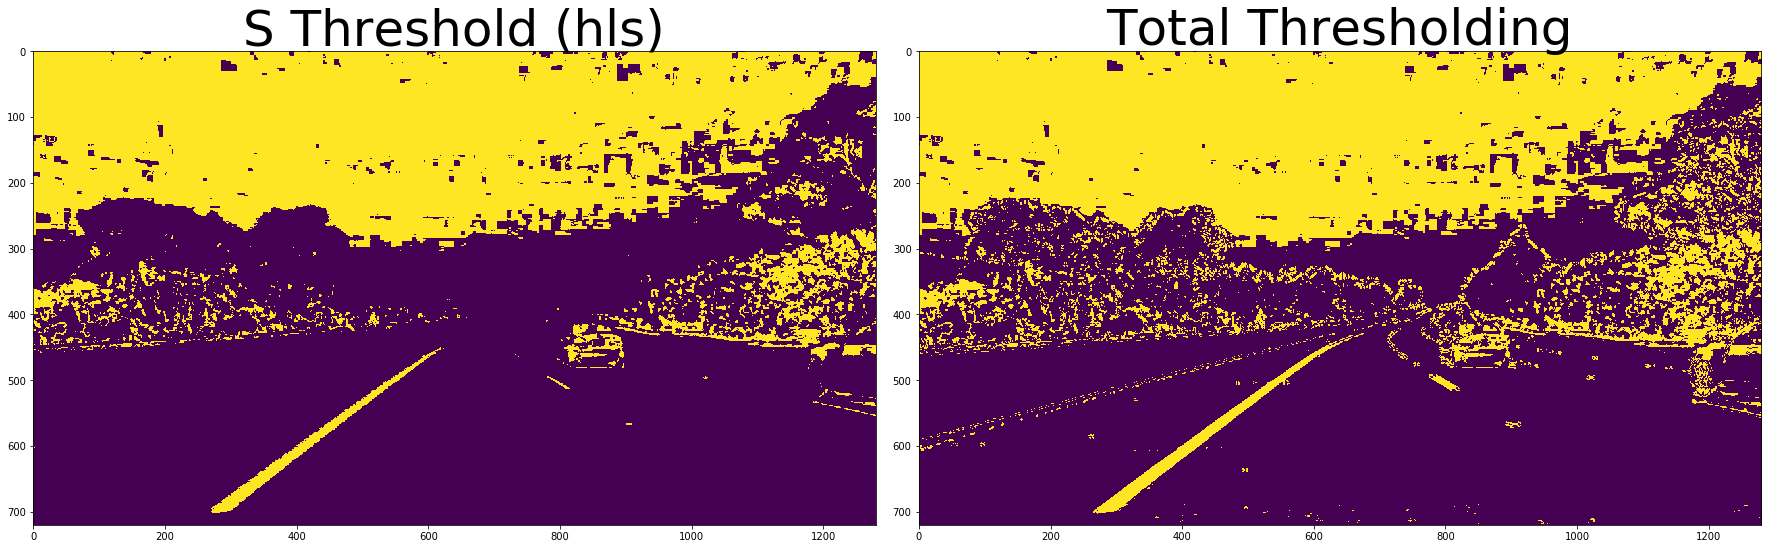

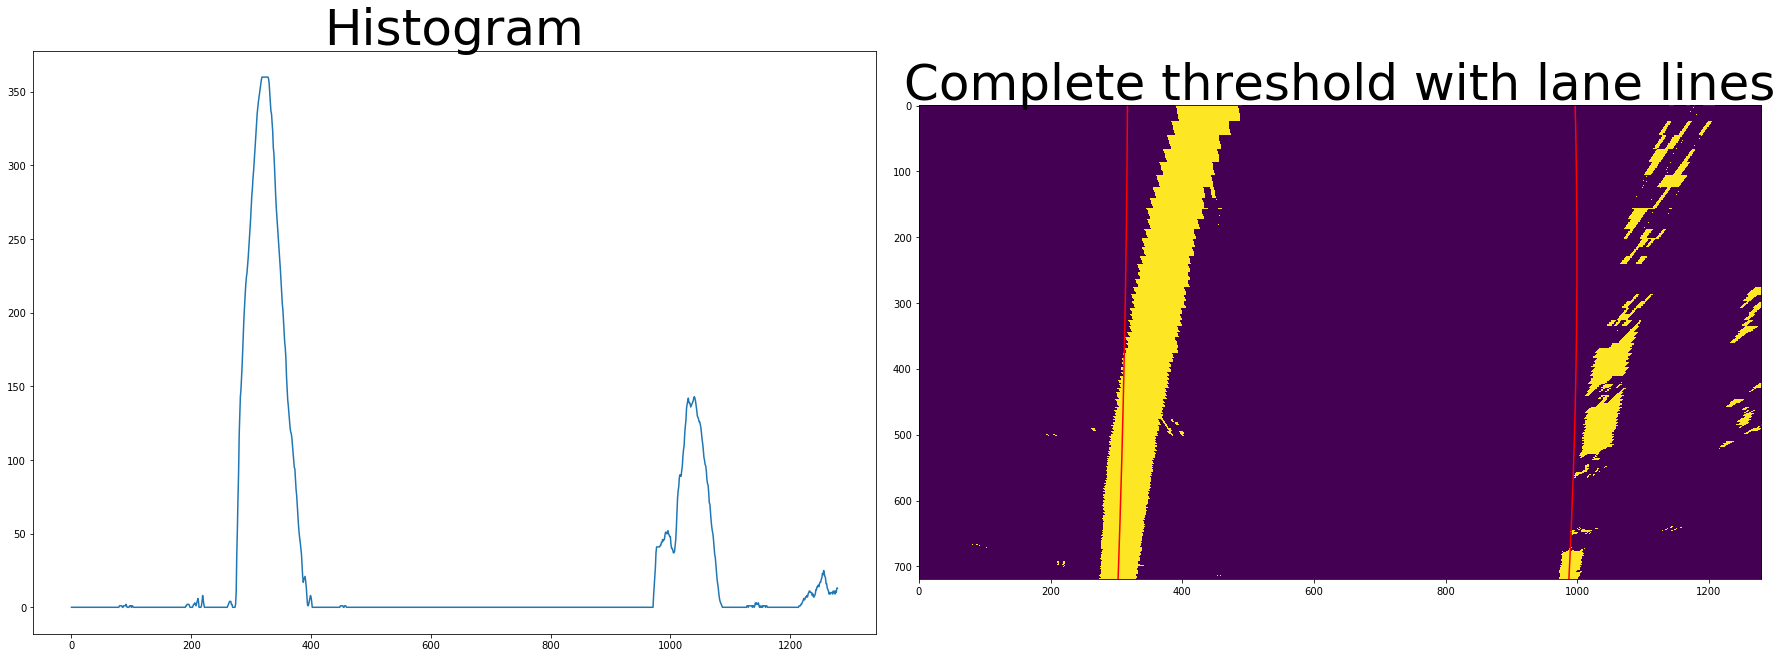

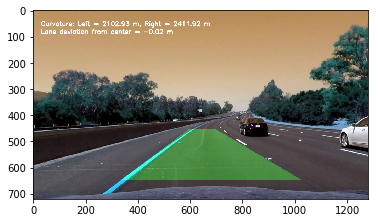

In [6]:
# Initialise globals
left_lane = np.array([-4.92440553e-05, 3.18705689e-02, 3.00252752e+02])
right_lane = np.array([5.49575122e-05,-3.81039511e-02, 9.79876871e+02])
warpedImagePrev = np.zeros((img_size[1], img_size[0])).astype(np.uint8)

def pipeline(image, video=True):
    global left_lane
    global right_lane
    global warpedImagePrev
    image = undistort(image)
    
    # Apply each of the thresholding functions
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=7, thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=7, thresh=(20, 100))
    multiPlot(gradx, "Gradient Threshold X", grady, "Gradient Threshold Y", video)
    
    mag_binary = mag_thresh(gray, sobel_kernel=7, mag_thresh=(30, 250))
    dir_binary = dir_threshold(gray, sobel_kernel=29, thresh=(0.7, 1.2))
    multiPlot(mag_binary, "Gradient Magnitude", dir_binary, "Gradient Direction", video)

    colourThreshold = hls_select(image, s_thresh=(100, 255))
    
    # Combine thresholds into single binary image
    thresholdImage = np.zeros_like(dir_binary)
    thresholdImage[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (colourThreshold == 1)] = 1
    multiPlot(colourThreshold, "S Threshold (hls)", thresholdImage, "Total Thresholding", video)
    
    # Transform perspective
    warpedImage = cv2.warpPerspective(thresholdImage, warpMatrix, (thresholdImage.shape[1], thresholdImage.shape[0])).astype(int)
    
    # Blend current and previous frames
    warpedImageTmp = warpedImage.copy()
    warpedImage = warpedImage | warpedImagePrev
    warpedImagePrev = warpedImageTmp
    
    # Histogram
    if not video:
        histogram = np.sum(warpedImage[warpedImage.shape[0]//2:,:], axis=0)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.plot(histogram)
        ax1.set_title("Histogram", fontsize=50)
    
    # Find lanes...
    left_lane_prev = left_lane.copy()
    right_lane_prev = right_lane.copy()
    
    left_lane, right_lane, leftx, lefty, rightx, righty = findLaneLines(warpedImage)
    
    #  ... and low pass filter the result
    left_lane = (left_lane * 0.15) + (left_lane_prev * 0.85)
    right_lane = (right_lane * 0.15) + (right_lane_prev * 0.85)
    
    left_curverad, right_curverad, lane_deviation = getCurvature(leftx, lefty, rightx, righty, warpedImage.shape)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(thresholdImage).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, img_size[1]-1, num=img_size[1])
    left_fitx = left_lane[0]*ploty**2 + left_lane[1]*ploty + left_lane[2]
    right_fitx = right_lane[0]*ploty**2 + right_lane[1]*ploty + right_lane[2]

    # Show image with lane lines plotted
    if not video:
        ax2.imshow(warpedImage)
        ax2.set_title("Complete threshold with lane lines", fontsize=50)
        ax2.plot(left_fitx, ploty, color='red')
        ax2.plot(right_fitx, ploty, color='red')
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, unwarpMatrix, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Add some text to the image
    curvature_text = "Curvature: Left = " + str(np.round(left_curverad, 2)) + " m, Right = " + str(np.round(right_curverad, 2)) + " m"
    cv2.putText(result, curvature_text, (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
    deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation)
    cv2.putText(result, deviation_text, (30, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

    if not video:
        plt.figure()
        plt.imshow(result)

    return result



make_video = False

# Grab a few frames from the video for testing
if not make_video:
    video = cv2.VideoCapture("project_video.mp4")
    success,img = video.read()
    frameNum = 0
    success = True
    while success:
        if frameNum % (285) == 0:
        #if frameNum % (100) == 0:
            output = pipeline(img, make_video)
        success,img = video.read()
        frameNum += 1
        
# Do full video output with no sample images
if make_video:
    video_output = 'project_video_output.mp4'

    clip1 = VideoFileClip('project_video.mp4')
    white_clip = clip1.fl_image(pipeline)
    %time white_clip.write_videofile(video_output, audio=False)
